# Predicting Aryl Hydrocarbon Receptor (AHR) activity of small molecules with Dask

In [1]:
import os

ROOT_DIR = os.path.abspath(os.getcwd())
DATASET_DIR = "{}/data".format(ROOT_DIR)
DATASET_DIR

'/home/jovyan/data'

In [2]:
import sys

import dask.dataframe as dd
from dask.dataframe.multi import concat
from dask_ml.model_selection import GridSearchCV

from matplotlib import pyplot
import numpy as np
import pandas as pd
from pprint import pprint
import re

from scipy import stats
import shap
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer, scale

ROOT_DIR = os.pardir
sys.path.insert(0, os.path.abspath(ROOT_DIR))

# Display pipelines and other objects
from sklearn import set_config
set_config(display="diagram")

# Preprocess the data

In [3]:
dataset = dd.read_csv("{}/nr-ahr.csv".format(DATASET_DIR))
features = dataset.columns.tolist()
target = "Activity"

pattern = re.compile("PubChem|BCUTMACCS")
cols_bcut_maccs_pubchem = [x for x in dataset.columns.tolist() if not pattern.match(x) is None]
cols_to_transform = [y for y in features if not y in cols_bcut_maccs_pubchem]
cols_to_transform.remove(target)

## DASK dataframe do not allow the use of inplace, since it distributes portions of the dataframe
dataset = dataset.dropna()
dataset = dataset.reset_index()
dataset = dataset.drop(["index"], axis=1)

# You need to call the actual compute function. It concatenates all the Dask 
# DataFrame partitions into a single pandas DataFrame
print(dataset.isna().any().sum().compute())


## Scale selected columns from the dataset and merge the result with the remaining ones.
sc = StandardScaler()
transformed_ = sc.fit_transform(dataset[cols_to_transform])
pd_transformed_ = pd.DataFrame(transformed_, columns =cols_to_transform)

# A dask dataframe does not have a concatenate function. use the "multi.concat" function
dataset_transformed = concat([dd.from_pandas(pd_transformed_, npartitions=3).compute()
                                       , dataset[cols_bcut_maccs_pubchem].compute()
                                       , dataset[target].compute()], axis=1)

0


In [4]:
# Randomly splitting the dataframe
random_state=42
train, test = dataset_transformed.random_split([0.8, 0.2], random_state=42)
X_train, y_train = train[train.columns.difference([target])], train[target]
X_test, y_test = train[test.columns.difference([target])], test[target]

# Set up the Dask Client

In [5]:
import joblib
from dask.distributed import Client
from dask.distributed import LocalCluster

## This assumes you have a local cluster. If not, create a instance (e.g.: a KubeCluster)
Client(LocalCluster())

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34785 instead


Client Scheduler: tcp://127.0.0.1:38495 Dashboard: http://127.0.0.1:34785/status,Cluster Workers: 2 Cores: 2 Memory: 2.58 GB


# Perform grid search to get the best model

In [6]:
kfold = 3 
# scoring = {'f1': 'f1_weighted', 'jaccard':'jaccard'} #, 'accuracy': 'accuracy'
scoring = ['f1_weighted']
params_grid_rf = {  'bootstrap': [True]
                  , 'max_depth': [5, 10, 30, None]
                  , 'criterion': ['gini'] # , 'entropy'
                  , 'max_features': ['auto']
                  , 'min_samples_split': [5]
                  , 'n_estimators': [150, 250, 300, 400]
                 }

with joblib.parallel_backend("dask"):
        rfc = RandomForestClassifier(random_state=random_state)
        grid_searcher = GridSearchCV(estimator = rfc, param_grid = params_grid_rf, cv = kfold, n_jobs = 1, scoring = 'f1_weighted', return_train_score=True)
        grid_searcher.fit(X_train, y_train)

In [7]:
model = grid_searcher.best_estimator_
model

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=400,
                       random_state=42)

In [8]:
print("Best parameters : {}".format(model.get_params))
print("Best score : {}".format(grid_searcher.best_score_))
y_train_pred = model.predict(X_train)

Best parameters : <bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=400,
                       random_state=42)>
Best score : 0.7832560203597955


In [9]:
f1_weighted = f1_score(y_train, y_train_pred, average="weighted")
f1_micro = f1_score(y_train, y_train_pred, average="micro")
f1_macro = f1_score(y_train, y_train_pred, average="macro")
print("Train F1-score weighted = {}".format(f1_weighted))
print("Train F1-score micro = {}".format(f1_micro))
print("Train F1-score macro = {}".format(f1_macro))

Train F1-score weighted = 0.9926519706078825
Train F1-score micro = 0.9926519706078825
Train F1-score macro = 0.9926519706078825


# Evaluate on a test set

In [10]:
X_test, y_test = test[test.columns.difference([target])], test[target]
y_test_pred = model.predict(X_test)
f1_weighted_test = f1_score(y_test, y_test_pred, average="weighted")
f1_micro_test = f1_score(y_test, y_test_pred, average="micro")
f1_macro_test = f1_score(y_test, y_test_pred, average="macro")
print("Test F1-score weighted = {}".format(f1_weighted_test))
print("Test F1-score micro = {}".format(f1_micro_test))
print("Test F1-score macro = {}".format(f1_macro_test))

Test F1-score weighted = 0.8362553037826126
Test F1-score micro = 0.8363636363636363
Test F1-score macro = 0.8361469712015888


# Explain predictions with SHAP

In [11]:
explainer = shap.TreeExplainer(model)

# SHAP expects Pnadas data frames. So we'll compute
X_train_pd = X_train.compute()
shap_values = explainer.shap_values(X_train_pd)

In [12]:
# visualize the first prediction's explanation 
shap.initjs()

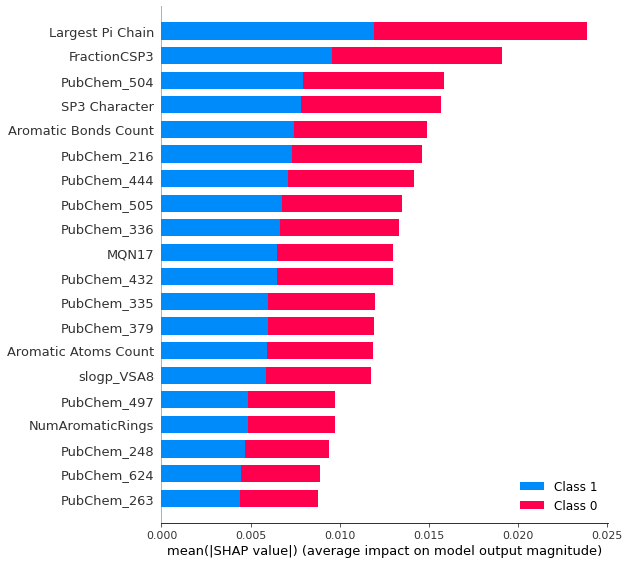

In [13]:
shap.summary_plot(shap_values, X_train_pd, plot_type='bar');

In [14]:
# The mean prediction of your model on the data (for each categorical outcome).
explainer.expected_value

In [15]:
## Explain the contribution of the first 20 features on the prediction of the whole data set
shap.force_plot(
    explainer.expected_value[0],  
    shap_values[0],
    X_train_pd.iloc[:, :20]
)

In [16]:
# Shap values all all features for the first instance/row of the dataset
shap.force_plot(
    explainer.expected_value[0],  
    shap_values[0][0],
    X_train_pd.iloc[:1, :]
)

# start_index = 1
# end_index = 2
# sv = explainer.shap_values(X_train_pd.iloc[start_index:end_index,:])
# shap.force_plot(
#     explainer.expected_value[0],  
#     sv[0][0],
#     X_train_pd.iloc[:1],
# )

In [17]:
# Shap values of the first 10 features for the first instance/row of the dataset
shap.force_plot(
    explainer.expected_value[0],  
    shap_values[0][0][:10],
    X_train_pd.iloc[:1, :10]
)

## SHAP Dependence Plots
SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

* Reference(s):
>- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html#Explain-predictions

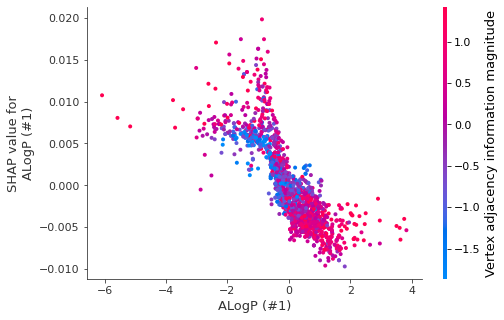

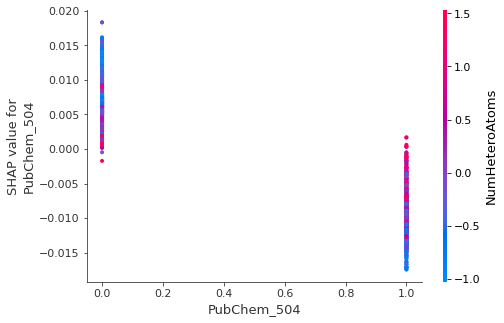

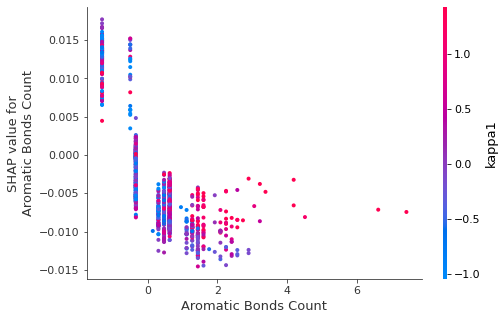

In [22]:
# Here we display the dependency plots of the featuees "ALogP (#1)", "PubChem_504", and "Aromatic Bonds Count" on the whole dataset

for name in ["ALogP (#1)", "PubChem_504", "Aromatic Bonds Count"]:
    shap.dependence_plot(name, shap_values[0], X_train_pd, display_features=X_train_pd)